In [1]:
import os 
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as  models
import torch.nn as nn 
import torch.nn.functional as F 
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

In [2]:
data_dir='Garbage classification/Garbage classification'
classes=os.listdir(data_dir)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [3]:
transformations=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])
dataset=ImageFolder(data_dir,transform=transformations)

In [4]:
def show_sample(img,label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1,2,0))

Label: cardboard (Class No: 0)


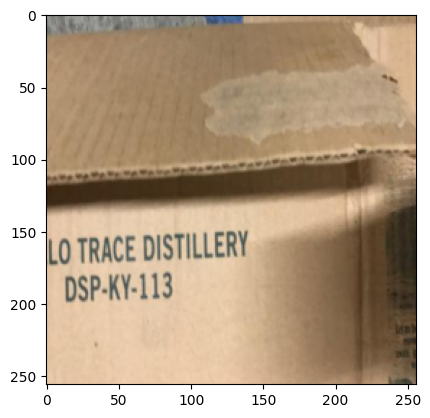

In [5]:
img,label=dataset[12]
show_sample(img,label)

Label: metal (Class No: 2)


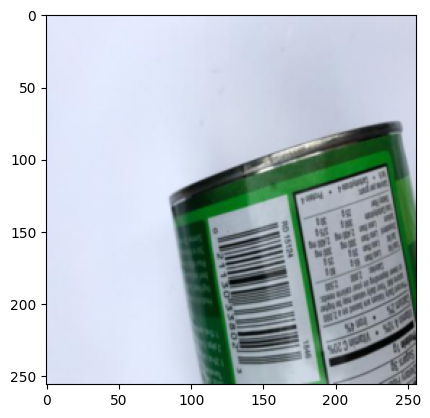

In [6]:
img,label=dataset[1000]
show_sample(img,label)

In [7]:
dataset.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [8]:
dataset.imgs

[('Garbage classification/Garbage classification\\cardboard\\cardboard1.jpg',
  0),
 ('Garbage classification/Garbage classification\\cardboard\\cardboard10.jpg',
  0),
 ('Garbage classification/Garbage classification\\cardboard\\cardboard100.jpg',
  0),
 ('Garbage classification/Garbage classification\\cardboard\\cardboard101.jpg',
  0),
 ('Garbage classification/Garbage classification\\cardboard\\cardboard102.jpg',
  0),
 ('Garbage classification/Garbage classification\\cardboard\\cardboard103.jpg',
  0),
 ('Garbage classification/Garbage classification\\cardboard\\cardboard104.jpg',
  0),
 ('Garbage classification/Garbage classification\\cardboard\\cardboard105.jpg',
  0),
 ('Garbage classification/Garbage classification\\cardboard\\cardboard106.jpg',
  0),
 ('Garbage classification/Garbage classification\\cardboard\\cardboard107.jpg',
  0),
 ('Garbage classification/Garbage classification\\cardboard\\cardboard108.jpg',
  0),
 ('Garbage classification/Garbage classification\\cardboa

In [9]:
random_seed = 42
torch.manual_seed(random_seed)

In [10]:
print(len(dataset))

2527


In [11]:
train_data,val_data,test_data=random_split(dataset,[1593,176,758])
print(len(train_data),len(val_data),len(test_data))

1593 176 758


In [12]:
batch_size=32

In [13]:
train_DL=DataLoader(train_data,batch_size,shuffle=True)
val_DL=DataLoader(val_data,batch_size,shuffle=True)

In [14]:
def show_batch(DL):
    for images,labels in DL:
        fig,ax=plt.subplots(figsize=(12,6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

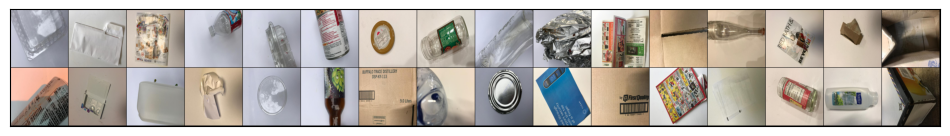

In [15]:
show_batch(train_DL)

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [17]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

D:\Anconda_WIN\envs\PytorchENV\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anconda_WIN\envs\PytorchENV\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
train_DL=DeviceDataLoader(train_DL,device)
val_DL=DeviceDataLoader(val_DL,device)
to_device(model,device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [21]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
model = to_device(ResNet(), device)

D:\Anconda_WIN\envs\PytorchENV\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anconda_WIN\envs\PytorchENV\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
evaluate(model, val_DL)

{'val_loss': 1.7954190969467163, 'val_acc': 0.1510416716337204}

In [30]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 1.5e-5

history = fit(num_epochs, lr, model, train_DL, val_DL, opt_func)

Epoch 1: train_loss: 1.6678, val_loss: 1.5328, val_acc: 0.7396
Epoch 2: train_loss: 1.4440, val_loss: 1.3847, val_acc: 0.7500
Epoch 3: train_loss: 1.3111, val_loss: 1.2842, val_acc: 0.8646
Epoch 4: train_loss: 1.2207, val_loss: 1.2220, val_acc: 0.9062
Epoch 5: train_loss: 1.1576, val_loss: 1.1846, val_acc: 0.9323
Epoch 6: train_loss: 1.1182, val_loss: 1.1687, val_acc: 0.9167
Epoch 7: train_loss: 1.0960, val_loss: 1.1436, val_acc: 0.9375
Epoch 8: train_loss: 1.0829, val_loss: 1.1424, val_acc: 0.9323
Epoch 9: train_loss: 1.0752, val_loss: 1.1328, val_acc: 0.9427
Epoch 10: train_loss: 1.0689, val_loss: 1.1348, val_acc: 0.9323
Epoch 11: train_loss: 1.0681, val_loss: 1.1245, val_acc: 0.9583
Epoch 12: train_loss: 1.0613, val_loss: 1.1262, val_acc: 0.9427
Epoch 13: train_loss: 1.0664, val_loss: 1.1239, val_acc: 0.9583
Epoch 14: train_loss: 1.0594, val_loss: 1.1265, val_acc: 0.9427
Epoch 15: train_loss: 1.0587, val_loss: 1.1221, val_acc: 0.9427
Epoch 16: train_loss: 1.0547, val_loss: 1.1182, v

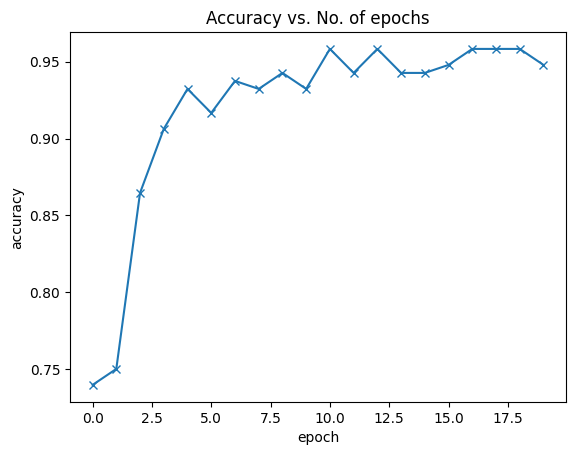

In [32]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

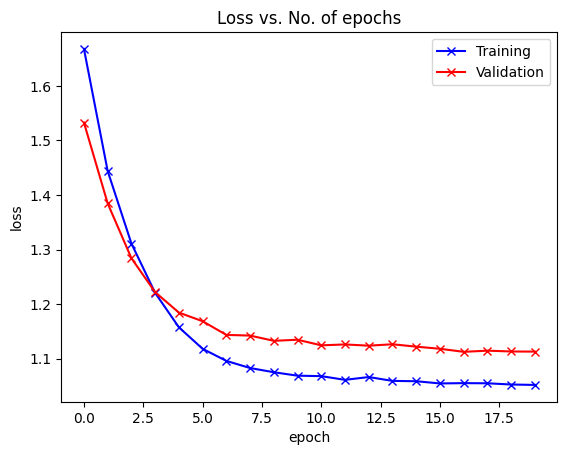

In [33]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [34]:
def predict_image(img, model):
    x = to_device(img.unsqueeze(0), device)
    y = model(x)
    prob, preds  = torch.max(y, dim=1)
    return dataset.classes[preds[0].item()]

Label: glass , Predicted: glass


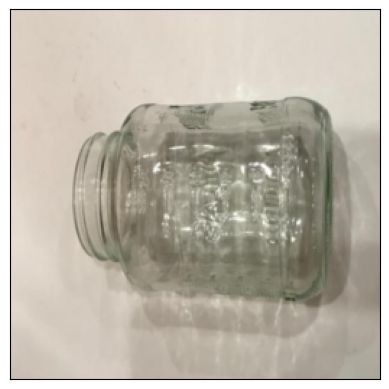

In [41]:
img, label = test_data[20]
plt.imshow(img.permute(1, 2,0))
plt.xticks([])
plt.yticks([])
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [50]:
import gradio as gr
from PIL import Image

def predict_image(img, model, device, dataset):
    img = transform(img).unsqueeze(0)
    # Move to the correct device
    x = img.to(device)
    # Make prediction
    y = model(x)
    prob, preds = torch.max(y, dim=1)
    # Return class name
    return dataset.classes[preds.item()]

# Gradio interface function
def gradio_predict(img):
    return predict_image(img, model, device, dataset)

# Set up Gradio interface
gr.Interface(
    fn=gradio_predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Text(),
    title="Image Classifier",
    description="Upload an image to get its predicted class."
).launch(share=False)


* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.
